<h1>DAY3 通し課題</h1>
<br>
特徴選択を適切に実施する<br>
木モデル(決定木、ランダムフォレスト、アダブースト)を利用する<br>
ニューラルネットワークを利用する<br>
DAY2後宿題提出時のモデルと精度を比較す<br>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn as sk
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel

# for SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# from common_func import plot_decision_regions
import seaborn as sns

データの読み込み

In [3]:
df_read = pd.read_csv("ks-projects-201801.csv")

前処理<br>
・不要なカラム削除<br>
・stateのsussessful,failed以外を除外<br>
・カテゴリカル変数に変換<br>
・ホールドアウトのためデータ分割

In [4]:
# 不要なカラムを削除
# pledged, backers を削除 これらは達成後の指標のため
# currency, goal を削除 代わりにusd_goal_realを使う
rm_col = ['ID','name','currency','goal','backers','pledged','usd pledged','usd_pledged_real', 'deadline','launched']
df_drop = df_read.drop(rm_col, axis = 1)
df_drop.info()

#stateからsuccessfulとfailed以外を除外
df_state = df_drop[ (df_drop['state'] == 'successful') | (df_drop['state'] == 'failed') ]
df_state.state.value_counts()

#カテゴリカル変数,boolean
#df_ks_data_all = pd.get_dummies(df_ks_data,  columns=dummy_items ,drop_first = True)
dummy = ['category','main_category','state','country']
df_cat = pd.get_dummies(df_state, columns=dummy)
#print(df_set.columns.values.tolist())

df=df_cat.drop('state_failed', axis=1)

# ホールドアウト法のためにデータ分割
dftrain, dftest = train_test_split(df, test_size=0.2, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   category       378661 non-null  object 
 1   main_category  378661 non-null  object 
 2   state          378661 non-null  object 
 3   country        378661 non-null  object 
 4   usd_goal_real  378661 non-null  float64
dtypes: float64(1), object(4)
memory usage: 14.4+ MB


<h2>特徴選択</h2>

特徴選択には主に3つの方法がある<br>
・フィルタ方<br>
・ラッパー法<br>
・埋め込み法<br>
<br>
今回は量的変数がusd_goal_realのみのためフィルタ法で相関は見れない<br>
<br>
<br>

<h3>ラッパー法（ステップワイズ法）</h3>

In [4]:
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
#estimator = LinearRegression(normalize=False)
estimator = SGDClassifier(loss='log', random_state=1234)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=2, scoring='accuracy')

y=dftrain["state_successful"].values
x=dftrain.drop(["state_successful"],axis=1).values

# fitで特徴選択を実行
rfecv.fit(x, y)

KeyboardInterrupt: 

結果<br>
<pre>RFECV(cv=5,
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=1000, n_iter_no_change=5, n_jobs=None,
                              penalty='l2', power_t=0.5, random_state=1234,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)
</pre>

In [36]:
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[ 79 103 137  51 169 180  47  41  22 102 127  56  25 159 199 135 130 112
 197 128  70 160 181 139  24  69  26  36 177  97 151  17 185  39 198 175
  86  20  77 107  74  68  80  44 194 164  95 157  82 173 145 188 120  32
  59  14  38 110 163  73 161  99  55  40 148 182  75  43  33 149  93  29
 118  13 106 171  42 117  85 131 146 178 174 129 192 143 153 108  60 179
 167  49 113  81  61 183  27  63 126  66  48  65 186 190  62  71 170  45
  53  91  64 166 140 176  35  37  46 125 147 191 155  92 152 156 104 111
  31 165 105  78   6  83 132 100 133 101 158   3 196  30 144 162  11 122
 184 154 116 193 168  10  88 187 136  89  34 123 172  76 141 115  19   7
  15  12  58   9  57   8  54  21   5  28  23   2   4   1 150  52 134  67
 124  50  94  96  72  18 109 119 114 195 189  98 138  84 142  90  87 121
  16]


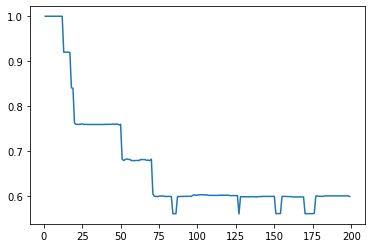

In [37]:
# 特徴数とスコアの変化をプロット
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [55]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [56]:
# 削除してもよい特徴の名前を取得する
remove_feature = dftrain.columns[remove_idx]
remove_featuref

IndexError: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 199

In [1]:
# 削除すべき特徴を削除して計算してみる。
delete_item = dftrain.columns[removed_idx]
dftrain_w = dftrain.drop(delete_item,axis=1)

y = dftrain_w['state_successful'].values
x = dftrain_w.drop('state_successful', axis=1).values

clf = SGDClassifier(loss='log', penalty='l2',alpha=0.0001, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

#quant_var_list = ks_data.get_quant_var_list()
#valid_hold = Valid_hold(df_ks_result, model_alg, 5, quant_var_list)
#clf = valid_hold.run()

#print(clf.best_params_, clf.best_score_)

NameError: name 'dftrain' is not defined

DAY3のnotebookと同じ流れなのにエラーになる<br>
何かがおかしいが良くわからない<br>

<h2>埋め込み法<h3>

In [5]:
# データ分割
# sdftrain, sdftest = train_test_split(df, train_size=0.1, test_size=1000, random_state=0)
sdftrain, sdftest = train_test_split(df, test_size=0.2, random_state=0)

In [5]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

In [ ]:

y = dftrain['state_successful'].values
x = dftrain.drop('state_successful', axis=1).values

# fitで特徴選択を実行
sfm.fit(x, y)

C:\Users\namik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.361703287140699, tolerance: 5.748361520648825
  tol, rng, random, positive)
C:\Users\namik\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.425224336337124, tolerance: 5.7518173132173605
  tol, rng, random, positive)


計算が終わらない...<br>
ConvergenceWarningが出る

In [ ]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

In [ ]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

In [ ]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

In [ ]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

<h3>決定木</h3>

In [15]:
# データ分割
# sdftrain, sdftest = train_test_split(df, train_size=0.1, test_size=1000, random_state=0)
dftrain, dftest = train_test_split(df, test_size=0.2, random_state=0)

In [11]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

y_train = dftrain['state_successful'].values
x_train = dftrain.drop('state_successful', axis=1).values
x_test = dftest.drop('state_successful', axis=1).values

clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
clf = clf.fit(x_train, y_train)
print("score=", clf.score(x_train, y_train))
print(clf.predict(x_test)) #予測したい場合

score= 0.7292115775985528
[0 1 0 ... 0 0 0]


In [12]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=["x1","x2"]).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

[5.53854063e-01 9.88574986e-04 6.79468438e-04 1.12654425e-03
 8.47790235e-04 1.81941006e-04 7.56751591e-04 2.35864381e-03
 3.55109605e-03 1.10876468e-02 5.82900981e-04 2.02489954e-03
 4.85685211e-03 6.26464814e-04 1.59387065e-04 3.25632553e-04
 2.94625342e-04 1.12620338e-03 3.34293985e-04 3.64413992e-04
 1.12471971e-03 3.79206609e-04 8.50666379e-05 2.69743889e-04
 2.82159911e-03 1.41292813e-03 5.03176565e-04 6.65309927e-04
 2.57306042e-04 5.87434735e-04 5.41275318e-04 2.71641770e-03
 2.16109189e-04 7.79018024e-04 3.94750970e-04 5.41348118e-04
 9.51144811e-04 4.74433703e-04 9.78327543e-04 1.71248636e-03
 4.18340070e-03 1.10792131e-03 9.79196693e-04 3.63994450e-03
 1.51260155e-04 9.38563856e-04 9.23577677e-04 3.75920311e-04
 9.03902761e-04 3.80472835e-04 5.04419640e-04 2.84004828e-04
 4.00727859e-04 1.69553663e-03 9.92951816e-04 3.82015056e-03
 2.20838114e-03 8.95374864e-04 4.20914724e-04 1.61938736e-03
 8.86289026e-04 1.04825097e-03 1.06145188e-03 1.14836100e-03
 3.69216786e-04 9.542857

ValueError: Shape of passed values is (198, 1), indices imply (2, 1)

In [13]:
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=["x1", "x2"],  
                     class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

NameError: name 'StringIO' is not defined

<h3>ランダムフォレスト</h3>

In [19]:
from sklearn.ensemble import RandomForestClassifier

y_train = dftrain['state_successful'].values
x_train = dftrain.drop('state_successful', axis=1).values

clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(x_train, y_train)
print("score=", clf.score(x_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
dftrain(clf.feature_importances_, index=dftrain.feature_names).plot.bar(figsize=(7,2)) # ???
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

score= 0.5957262380342202
[8.18146782e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.74911108e-02 7.52724354e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.47275646e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.49895091e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

AttributeError: 'DataFrame' object has no attribute 'feature_names'

<h3>アダブースト</h3>

In [20]:
# データ分割
# sdftrain, sdftest = train_test_split(df, train_size=0.1, test_size=1000, random_state=0)
dftrain, dftest = train_test_split(df, test_size=0.2, random_state=0)

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

y_train = dftrain['state_successful'].values
x_train = dftrain.drop('state_successful', axis=1).values

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
clf.fit(x_train, y_train)
print("score=", clf.score(x_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=dftrain.columns).plot.bar(figsize=(7,2)) #???
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

score= 0.6633979045752619
[0.19198531 0.         0.         0.         0.         0.
 0.         0.         0.         0.02635677 0.         0.
 0.03276866 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0297763  0.         0.         0.         0.         0.
 0.         0.03263903 0.         0.         0.         0.
 0.         0.         0.         0.         0.02362752 0.
 0.         0.02871848 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02354964 0.         0.         0.         0.
 0.0335169  0.         0.         0.         0.         0.
 0.         0.         0.         0.02460453 0.         0.
 0.         0.01711022 0.         0.         0.         0.
 0.         0.         0.00253655 0.         0.         0.
 0.         0.         0.         0.         0.         0.03421798
 0.         0.         0.         0.         0.02955178 0.
 0.         0.        

ValueError: Shape of passed values is (198, 1), indices imply (199, 1)

<h3>NN</h3>

In [26]:
# データの準備

# データ分割
# sdftrain, sdftest = train_test_split(df, train_size=0.1, test_size=1000, random_state=0)
dftrain, dftest = train_test_split(df, test_size=0.2, random_state=0)

y_train = dftrain['state_successful'].values
X_train = dftrain.drop('state_successful', axis=1).values

y_test = dftest['state_successful'].values
X_test = dftest.drop('state_successful', axis=1).values

# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X_train=",X_train)
print()
print("X_test=",X_test)
print()
print("y_train=",y_train)
print()
print("y_test=",y_test)

X_train= [[4.5e+03 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 1.0e+00]
 [1.0e+04 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 1.0e+00]
 [7.0e+04 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 1.0e+00]
 ...
 [9.0e+02 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 1.0e+00]
 [7.0e+03 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 1.0e+00]
 [7.5e+03 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 1.0e+00]]

X_test= [[3.500e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [9.000e+02 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [9.747e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 ...
 [1.000e+04 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [7.500e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [5.500e+04 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]]

y_train= [[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]

y_test= [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [27]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=4))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

In [28]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

ValueError: Error when checking input: expected dense_3_input to have shape (4,) but got array with shape (198,)